In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


<Axes: title={'center': 'Daily Sales'}, xlabel='InvoiceDate'>

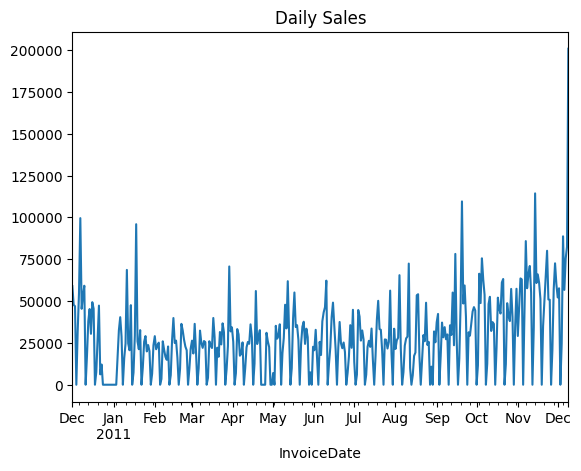

In [3]:
df = pd.read_csv('../data/data.csv', encoding='ISO-8859-1')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df[df['Quantity'] > 0]
df['TotalAmount'] = df['Quantity'] * df['UnitPrice']

# Daily Sales Aggregation
daily_sales = df.groupby(df['InvoiceDate'].dt.date)['TotalAmount'].sum()
daily_sales = pd.Series(daily_sales.values, index=pd.to_datetime(daily_sales.index))
daily_sales = daily_sales.asfreq('D').fillna(0)  # Fill missing days
daily_sales.plot(title="Daily Sales")


In [4]:
result = adfuller(daily_sales)
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')


ADF Statistic: -0.6332043578341069
p-value: 0.8633013269519445


Post-differencing p-value: 2.2787986800364563e-08


<Axes: title={'center': 'Differenced Daily Sales'}, xlabel='InvoiceDate'>

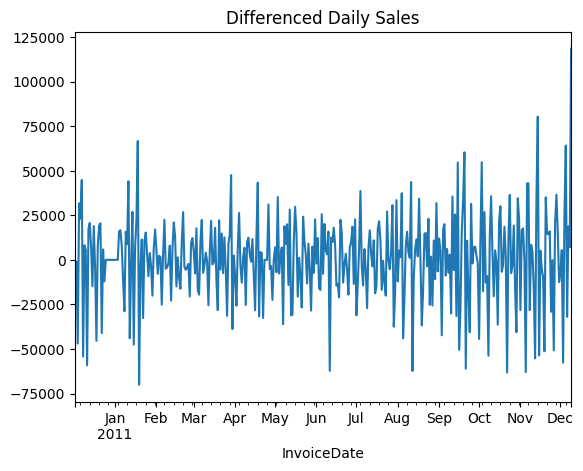

In [5]:
diff_sales = daily_sales.diff().dropna()

# Re-test
result = adfuller(diff_sales)
print(f'Post-differencing p-value: {result[1]}')

diff_sales.plot(title="Differenced Daily Sales")


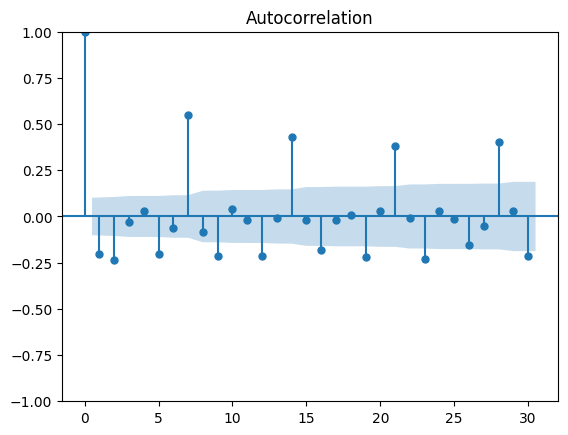

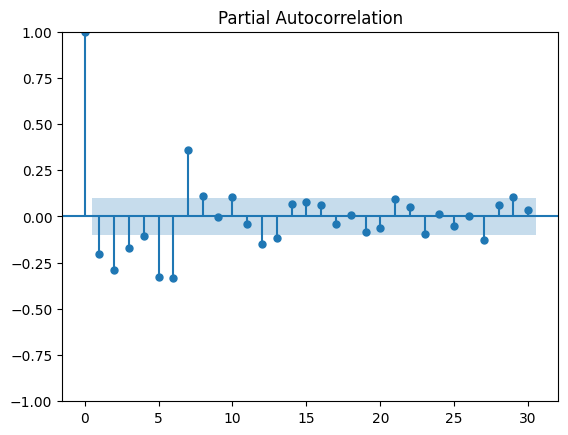

In [6]:
plot_acf(diff_sales, lags=30)
plot_pacf(diff_sales, lags=30)
plt.show()


In [7]:
model = SARIMAX(daily_sales, order=(1,1,1), seasonal_order=(1,1,1,7))
results = model.fit()
results.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                     
=========================================================================================
Dep. Variable:                                 y   No. Observations:                  374
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood               -4060.169
Date:                           Fri, 04 Jul 2025   AIC                           8130.338
Time:                                   15:42:10   BIC                           8149.852
Sample:                               12-01-2010   HQIC                          8138.092
                                    - 12-09-2011                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0578      0.137      0.422      0.673      -0.211       0.326
ma.L1         -0.7114      0.095     -7.484      0.000      -0.898      -0.525
ar.S.L7        0.1449      0.090      1.604      0.109      -0.032       0.322
ma.S.L7       -0.8668      0.061    -14.133      0.000      -0.987      -0.747
sigma2      3.382e+08   2.29e-10   1.48e+18      0.000    3.38e+08    3.38e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              4288.37
Prob(Q):                              0.86   Prob(JB):                         0.00
Heteroskedasticity (H):               2.42   Skew:                             2.27
Prob(H) (two-sided):                  0.00   Kurtosis:                        19.14
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.94e+33. Standard errors may be unstable.
"""

KeyError: 'lower TotalAmount'

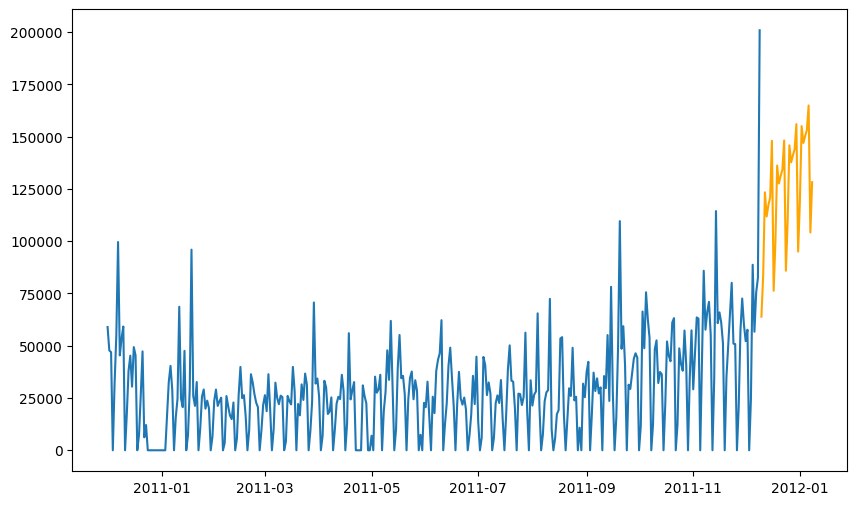

In [8]:
forecast = results.get_forecast(steps=30)
forecast_df = forecast.conf_int()
forecast_df['Forecast'] = forecast.predicted_mean

# Plot Forecast
plt.figure(figsize=(10,6))
plt.plot(daily_sales, label='Historical')
plt.plot(forecast_df['Forecast'], label='Forecast', color='orange')
plt.fill_between(forecast_df.index, 
                 forecast_df['lower TotalAmount'], 
                 forecast_df['upper TotalAmount'], 
                 color='pink', alpha=0.3)
plt.title("30-Day Sales Forecast")
plt.legend()
plt.show()
